## util

In [ ]:
import torch
import random
import os
import numpy as np
import matplotlib.pyplot as plt

def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def print_network(model, name):
    """Print out the network information."""
    num_params = 0
    for p in model.parameters():
        num_params += p.numel()
    #print(model)
    print(name)
    print("The number of parameters: {}".format(num_params))



def load_model(model, optimizer, resume, device):
    checkpoint = torch.load(resume, map_location=device)
    print('loaded weights from {}, step {}, best_unet_score {}'.format(
        resume, checkpoint['step'], checkpoint['best_unet_score']))

    model.load_state_dict(checkpoint['model_state_dict'])

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    epoch = checkpoint['epoch']
    best_net_accuracy = checkpoint['best_net_accuracy']

    return model, optimizer, epoch, best_net_accuracy


def save_model(path, epoch, model, optimizer, best_net_accuracy):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_net_accuracy': best_net_accuracy,
    }, path)

def UnNormalize(tensor,mean, std):
    
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
        # The normalize code -> t.sub_(m).div_(s)
    return tensor



def predict_plt(model, dataset,device ,sample = 8 ):
    model.eval()
    imgs = []
    preds = []
    with torch.no_grad():
        for i in range(0, sample):
            device = 'cuda' if next(model.parameters()).is_cuda else 'cpu'
            
            index = np.random.choice(len(dataset)) 

            img, label = dataset[index]

            img = img.to(device)
            #label = label.to(device)

            img = torch.unsqueeze(img,0) # mở dimen batchsize

            output = model(img)
            _, pred = torch.max(output, 1)
                    
            pred = int(pred)
            if pred == 0:
                pred = 'Dog'
            elif pred ==1:
                pred = 'Cat'
            imgs.append(img) 
            preds.append(pred) 


        figure, ax = plt.subplots(nrows=int(sample/8), ncols=8, figsize=(15, 10))
        k = 0
        for i in range(int(sample/8)):
            for j in range(8):
#=============img
            
                img = UnNormalize(tensor =imgs[k], mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)).cpu().numpy()
    #Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers
                img = np.squeeze(img, axis=0)  
                img = img.transpose((1, 2, 0))
            
                pred = preds[k]
                k+=1
                name = f'Predict: {pred}'
    #============== matplotlib show
                ax[i , j].imshow(img,interpolation="nearest")
                ax[i , j].set_title(name)
                ax[i , j].set_axis_off()

        plt.show()



def visualize_augmentations(dataset, sample = 8):

    figure, ax = plt.subplots(nrows=int(sample/8), ncols=8, figsize=(15, 10))
   
    for i in range(int(sample/8)):
        for j in range(8):
            index = np.random.choice(len(dataset)) 

            img, label = dataset[index]


    #=============img   
            img = UnNormalize(tensor =img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)).cpu().numpy()
    #Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers
           
            img = img.transpose((1, 2, 0))

    
            name = f'Label: {label}'
    #============== matplotlib show
            ax[i, j].imshow(img,interpolation="nearest")
            ax[i, j].set_title(name)
            ax[i, j].set_axis_off()

    plt.show()
    


class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1): # n luôn bằng 1 
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count # loss trung bình trên 1 batchsize

## dataset

In [ ]:
from torchvision import models, transforms
import glob
import json
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, ConcatDataset


class MyDataset(data.Dataset):
    def __init__(self, path, transform=None, mode="train"):
        self.file_list = self.get_img_list(path)
        self.transform = transform
        self.path = path
        print(f"{mode} Image Count: {len(self.file_list)}")
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.path,img_name)
        img = Image.open(img_path)
        
        img_transformed = self.transform(img)
        label = img_name[0:3]  #classfy_data\train\cat.0.jpg
        if label == "dog":
            label = 0
        elif label == "cat":
            label = 1

        return img_transformed, label
    

    def get_img_list(self,path):
        contents = os.listdir(path)
        files = [item for item in contents if os.path.isfile(os.path.join(path, item))]
        return files



def get_loader(img_path,image_size, batch_size, num_workers=0, mode='train'):
    """Builds and returns Dataloader."""

    train_transform = transforms.Compose([
                transforms.RandomResizedCrop(image_size, scale=(0.5,1.0)),
                #transforms.Resize(size = image_size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean= (0.485, 0.456, 0.406) , std =(0.229, 0.224, 0.225) )
    ])

    test_transform = transforms.Compose([
                transforms.Resize((image_size,image_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean= (0.485, 0.456, 0.406) , std=(0.229, 0.224, 0.225))
    ])
        

    if mode == 'train':
        dataset = MyDataset(path = img_path, transform=train_transform, mode="train")
        print('Visualize augmentations...')            	
        visualize_augmentations(dataset, sample=24)

        data_loader = DataLoader(dataset=dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=num_workers)
        return data_loader
        
        
    if mode == 'val' :
        dataset = MyDataset(path = img_path, transform=test_transform, mode="val")
        #print(batch_size)
        data_loader = DataLoader(dataset=dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=num_workers)

        return data_loader
                
        
    if mode == 'test':
        dataset = MyDataset(path = img_path, 
                            transform=test_transform, mode="test")
        return dataset

## train

In [ ]:
from torchvision.models import VGG16_Weights


class Solver(object):
    def __init__(self,cfg , train_loader, val_loader, test_dataset):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Data loader
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_dataset = test_dataset

#==========network
        self.net = self.config_network(cfg)
        print_network(self.net, name = 'VGG16')
        #self.net.to(self.device)
        
#========= config



    def config_network(self,cfg):
        use_pretrained = cfg['NETWORK']['use_pretrained']         
        net = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
     
        params_to_update = []

        update_params_name = ["classifier.6.weight", "classifier.6.bias"]

        for name, param in net.named_parameters():
            if name in update_params_name:
                param.requires_grad = True
                params_to_update.append(param)
                #print(name)
            else:
                param.requires_grad = False

        return net


    def set_Optimizer(self,cfg):
		# Opimizer
        if cfg['OPTIMIZER']['optim_name'] == 'adam':
            self.optimizer = torch.optim.AdamW(
                params       = filter(lambda p: p.requires_grad, self.net.parameters()), 
                lr           = cfg['OPTIMIZER']['lr'], 
                weight_decay = cfg['OPTIMIZER']['weight_decay']
            )
            optimizer_name = "Adam"


        else:
            self.optimizer = torch.optim.SGD(
				params       = filter(lambda p: p.requires_grad, self.net.parameters()), 
                lr           = cfg['OPTIMIZER']['lr'], 
                momentum     = cfg['OPTIMIZER']['momentum'],
                weight_decay = cfg['OPTIMIZER']['weight_decay']
            )
            optimizer_name = "SGD"
        return optimizer_name



    def train(self,cfg):

        eval_interval       = cfg['LOG']['eval_interval']

        criterior = nn.CrossEntropyLoss()
        loss_name = "Cross Entropy Loss"
        criterior.to(self.device)

        optimizer_name = self.set_Optimizer(cfg) 
        data_str = f"Optimizer: {optimizer_name}\nLoss: {loss_name}\n"
        print(data_str)

        print('====================================== Set up ===========================================')

        best_epoch_accuracy = 0
        loss_m = AverageMeter()
        epoch_corrects_m = AverageMeter()
        
        # load weight
        savedir = cfg['RESULT']['savedir']
        save_path =  os.path.join(savedir, 'best_score.pth')
        #print(save_path)

        if os.path.exists(save_path):
            self.unet, self.optimizer, epoch,best_epoch_accuracy = load_model(model = self.unet,optimizer = self.optimizer,resume = save_path)                                      
            print(f'Successfully Load best accuracy: {best_epoch_accuracy} at epoch :{epoch}')


        num_epochs = cfg['TRAIN']['num_epochs']
        self.net.to(self.device)

        print('====================================== Trainning ===========================================')
        

        
        for epoch in range(num_epochs):
            print("Epoch {}/{}".format(epoch, num_epochs))

                    
            epoch_loss = 0.0
            epoch_corrects = 0
            
            self.net.train()
            
            for i, (inputs, labels) in enumerate((self.train_loader)):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
    
                
                outputs = self.net(inputs)
                loss = criterior(outputs, labels)
                _, preds = torch.max(outputs, 1)
    
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad() 

                #epoch_loss += loss.item()*inputs.size(0)
                loss_m.update(loss.item(),  n =1) # batchsize loss
                epoch_corrects += torch.sum(preds==labels.data)
                   
                
                if (i+1) % 200 == 0 or i == 0:
                
                    print('Epoch: [{:>2d}/{}]  '
                        'Step [{:>4d}/{}]  ' 
                        'Cross Entropy Loss: {loss:>6.4f} '
                        'LR: {lr:.3e} '
                        .format(
                            epoch + 1, num_epochs,                            
                            i + 1, len(self.train_loader),
                            loss=loss_m.avg,
                            lr=self.optimizer.param_groups[0]['lr'],
                            )) 
        
                
                
                
            #epoch_loss = epoch_loss / len(self.train_loader)
            epoch_accuracy = float(epoch_corrects.double() / (len(self.train_loader)*cfg['DATALOADER']['batch_size']))
        
            print("TRAIN : Loss: {:.4f} Acc: {:.4f}".format(loss_m.avg, epoch_accuracy))

            #and epoch != 0
            if ((epoch+1) % eval_interval == 0 ) or (epoch+1) == num_epochs:
                    self.net.eval()
                    predict_plt(self.net,self.test_dataset,device = self.device,sample = 24)
                    epoch_corrects = 0
                    epoch_corrects_m.reset()
                    for inputs_val, labels_val in (self.val_loader):
                          
                            inputs_val = inputs_val.to(self.device)
                          
                            labels_val = labels_val.to(self.device)
                            outputs_val = self.net(inputs_val)
                          
                            _, preds_val = torch.max(outputs_val, 1)
                           
                            epoch_corrects += torch.sum(preds_val==labels_val.data) # cả batchsize --> phải chia cho batchsize để ra 1 ảnh 
                            epoch_corrects_m.update(torch.sum(preds_val==labels_val.data),  n =1 ) # 

                    epoch_accuracy = float(epoch_corrects.double() / (len(self.val_loader)*cfg['DATALOADER']['batch_size']))
                    epoch_accuracy= round(epoch_accuracy, 3)
                    print("VALIDATION :  Acc: {:.3f}".format( epoch_accuracy))
                    #print("VALIDATION :  epoch_corrects_m: {:.4f}".format( epoch_corrects_m.avg/cfg['DATALOADER']['batch_size']))

                    
                    if epoch_accuracy > best_epoch_accuracy: # json và best_model save theo unet_score
                            best_epoch_accuracy = epoch_accuracy
                            evaluation = {'Accuracy': best_epoch_accuracy, 'best_epoch':epoch+1 }
                            #print(evaluation)
                            #json.dump(evaluation, open(os.path.join(savedir, 'best_score.json'),'w'), indent='\t')
                            json.dump(evaluation, open('best_score.json','w'), indent='\t')
                            print("SAVE_MODEL")


                            save_model('best_score.pth', # checkpoint save theo hmean
                                    epoch,
                                    self.net,
                                    self.optimizer,
                                    best_epoch_accuracy)


                    self.net.train()
                    if (epoch+1) == num_epochs:
                        print("TRAINNING PROCESS FINISH")

## main

In [ ]:
import datetime
import wandb
import tqdm
import math
import yaml
import argparse
import torch.backends.cudnn


def main(cfg):
    seeding(cfg['SEED'])

    train_loader = get_loader(
                            img_path = cfg['DATASET']['train_datadir'],
                            image_size = cfg['DATASET']['image_size'], 
                            batch_size = cfg['DATALOADER']['batch_size'] , 
                            num_workers=cfg['DATALOADER']['num_workers'], 
                            mode='train')

    val_loader = get_loader(
                            img_path = cfg['DATASET']['val_datadir'],
                            image_size = cfg['DATASET']['image_size'], 
                            batch_size = cfg['DATALOADER']['batch_size'] , 
                            num_workers=0, 
                            mode='val')
    
    test_dataset = get_loader(
                            img_path= cfg['DATASET']['test_datadir'],
                            image_size=cfg['DATASET']['image_size'],
                            batch_size=cfg['DATALOADER']['batch_size'],
                            num_workers=cfg['DATALOADER']['num_workers'],
                            mode='test'
                            )
    
    Solver(cfg,train_loader,val_loader,test_dataset).train(cfg)

## config

In [2]:
cfg = {
    'SEED': 42,

    'DATASET':
    {    
        'train_datadir': '/kaggle/input/qqqqqqq/classfy_data/train',
        'val_datadir' : '/kaggle/input/qqqqqqq/classfy_data/val',
        'test_datadir': '/kaggle/input/qqqqqqq/classfy_data/test1',
        'image_size': 512 
    },
    
    'DATALOADER':
    {
        'batch_size': 16,
        'num_workers': 0
    },
    
    'NETWORK':
    {
        'use_pretrained': True
    },

    'TRAIN':
    {
        'num_epochs': 5,
    },

    'OPTIMIZER':
    {
        'optim_name': 'adam',
        'lr': 0.0001,
        'weight_decay': 0.00001,
        'momentum': 0.9
    },
    'LOG':
    {
        'eval_interval': 1
    },
    'RESULT':
    {
        'savedir': 'saving'
    }
}    

## Run

train Image Count: 24000
Visualize augmentations...


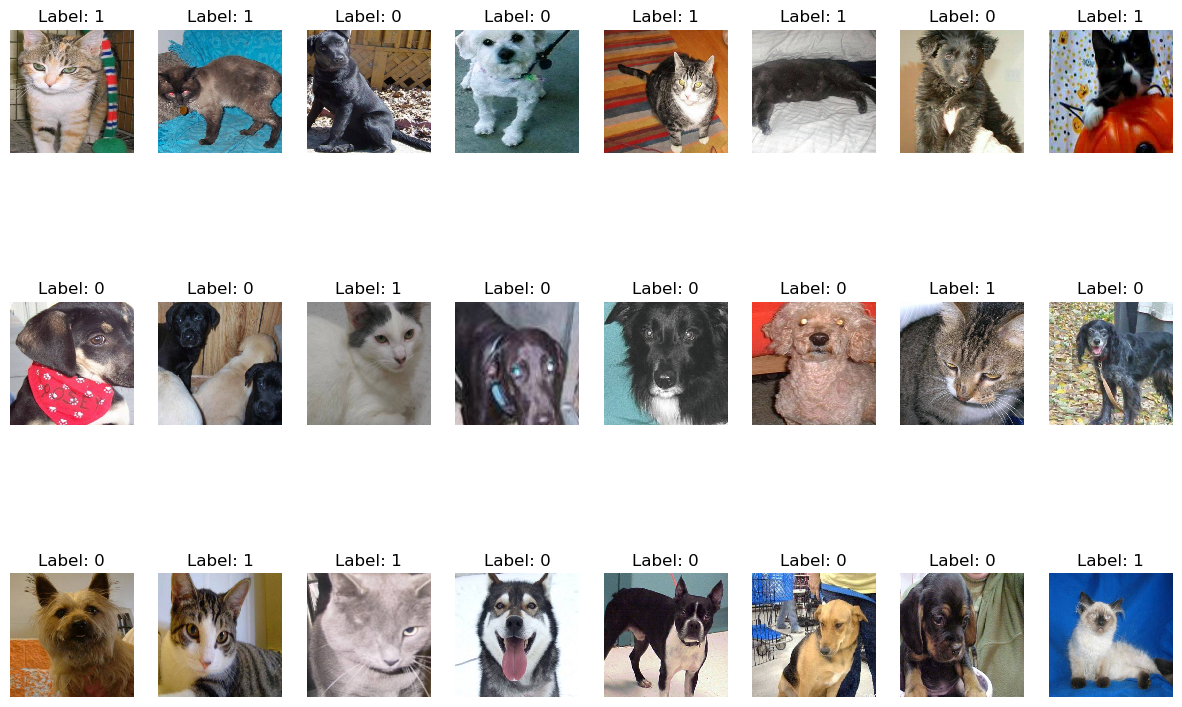

val Image Count: 1000
test Image Count: 12500


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 247MB/s]  


VGG16
The number of parameters: 134268738
Optimizer: Adam
Loss: Cross Entropy Loss

====================================== Set up ===========================================
====================================== Trainning ===========================================
Epoch 0/5
Epoch: [ 1/5]  Step [   1/1500]  Cross Entropy Loss: 0.6732 LR: 1.000e-04 
Epoch: [ 1/5]  Step [ 200/1500]  Cross Entropy Loss: 0.3199 LR: 1.000e-04 
Epoch: [ 1/5]  Step [ 400/1500]  Cross Entropy Loss: 0.2397 LR: 1.000e-04 
Epoch: [ 1/5]  Step [ 600/1500]  Cross Entropy Loss: 0.2041 LR: 1.000e-04 
Epoch: [ 1/5]  Step [ 800/1500]  Cross Entropy Loss: 0.1819 LR: 1.000e-04 
Epoch: [ 1/5]  Step [1000/1500]  Cross Entropy Loss: 0.1676 LR: 1.000e-04 
Epoch: [ 1/5]  Step [1200/1500]  Cross Entropy Loss: 0.1556 LR: 1.000e-04 
Epoch: [ 1/5]  Step [1400/1500]  Cross Entropy Loss: 0.1458 LR: 1.000e-04 
TRAIN : Loss: 0.1416 Acc: 0.9557


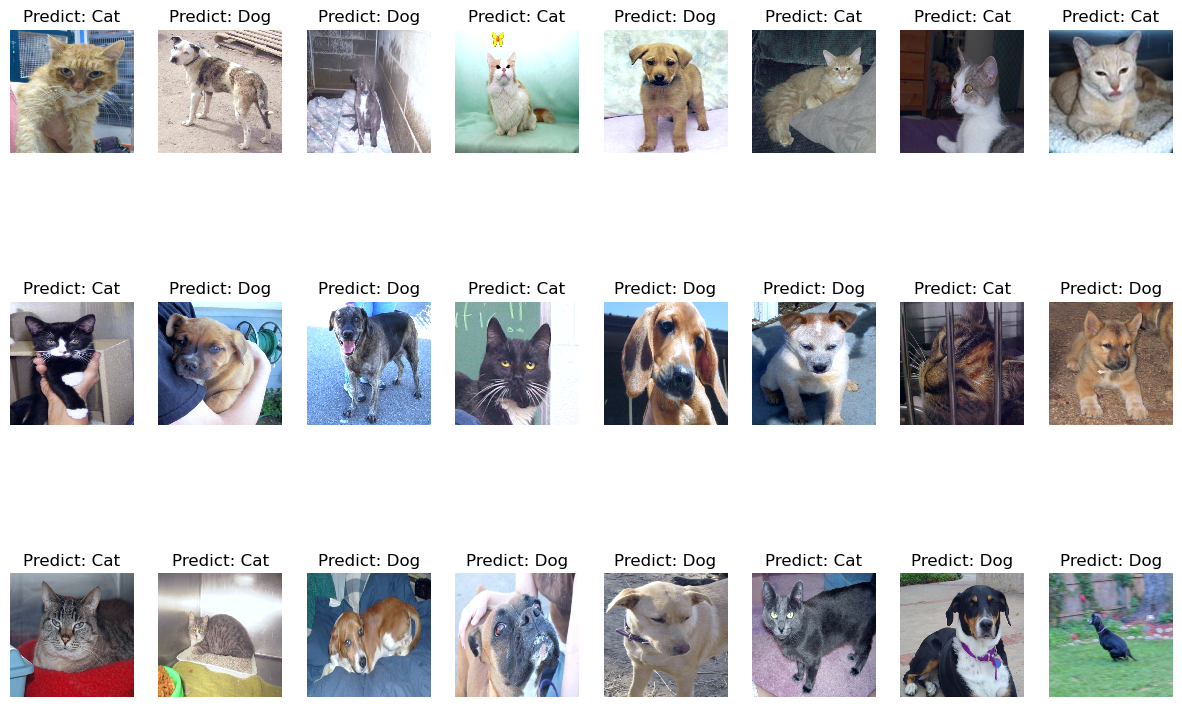

VALIDATION :  Acc: 0.975
SAVE_MODEL
Epoch 1/5
Epoch: [ 2/5]  Step [   1/1500]  Cross Entropy Loss: 0.1415 LR: 1.000e-04 
Epoch: [ 2/5]  Step [ 200/1500]  Cross Entropy Loss: 0.1358 LR: 1.000e-04 
Epoch: [ 2/5]  Step [ 400/1500]  Cross Entropy Loss: 0.1309 LR: 1.000e-04 
Epoch: [ 2/5]  Step [ 600/1500]  Cross Entropy Loss: 0.1263 LR: 1.000e-04 
Epoch: [ 2/5]  Step [ 800/1500]  Cross Entropy Loss: 0.1221 LR: 1.000e-04 
Epoch: [ 2/5]  Step [1000/1500]  Cross Entropy Loss: 0.1189 LR: 1.000e-04 
Epoch: [ 2/5]  Step [1200/1500]  Cross Entropy Loss: 0.1158 LR: 1.000e-04 
Epoch: [ 2/5]  Step [1400/1500]  Cross Entropy Loss: 0.1130 LR: 1.000e-04 
TRAIN : Loss: 0.1116 Acc: 0.9696


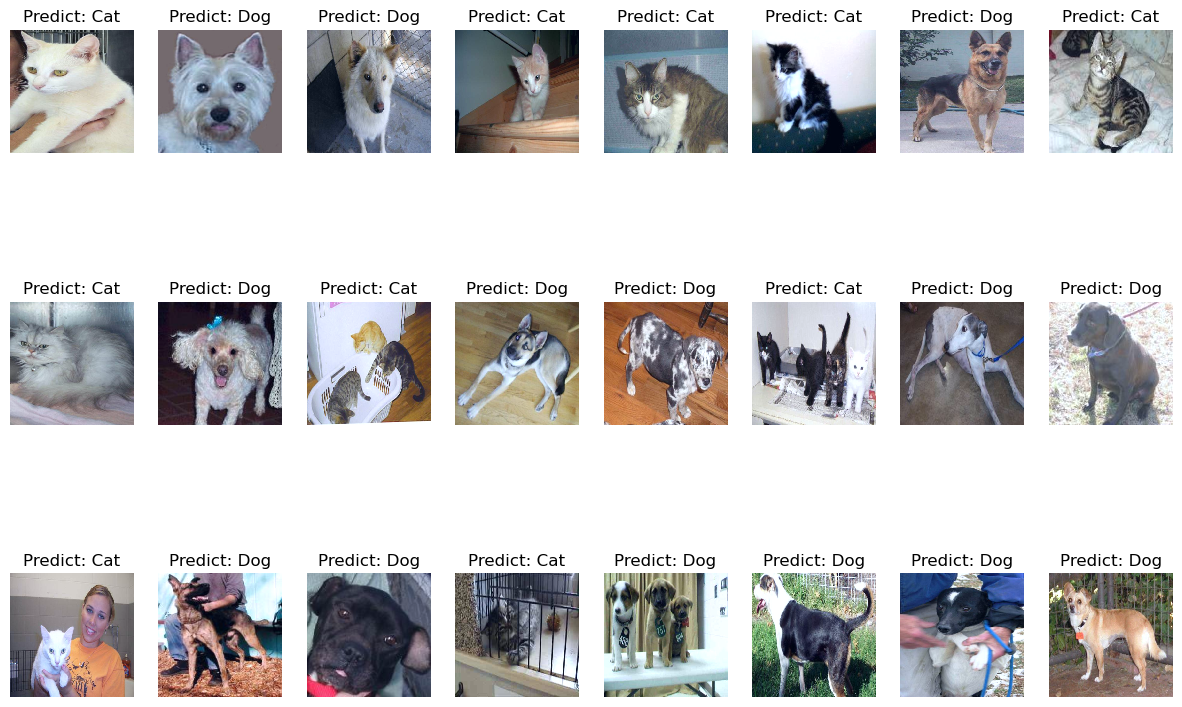

VALIDATION :  Acc: 0.978
SAVE_MODEL
Epoch 2/5
Epoch: [ 3/5]  Step [   1/1500]  Cross Entropy Loss: 0.1115 LR: 1.000e-04 
Epoch: [ 3/5]  Step [ 200/1500]  Cross Entropy Loss: 0.1093 LR: 1.000e-04 
Epoch: [ 3/5]  Step [ 400/1500]  Cross Entropy Loss: 0.1068 LR: 1.000e-04 
Epoch: [ 3/5]  Step [ 600/1500]  Cross Entropy Loss: 0.1049 LR: 1.000e-04 
Epoch: [ 3/5]  Step [ 800/1500]  Cross Entropy Loss: 0.1034 LR: 1.000e-04 
Epoch: [ 3/5]  Step [1000/1500]  Cross Entropy Loss: 0.1018 LR: 1.000e-04 
Epoch: [ 3/5]  Step [1200/1500]  Cross Entropy Loss: 0.1004 LR: 1.000e-04 
Epoch: [ 3/5]  Step [1400/1500]  Cross Entropy Loss: 0.0993 LR: 1.000e-04 
TRAIN : Loss: 0.0986 Acc: 0.9722


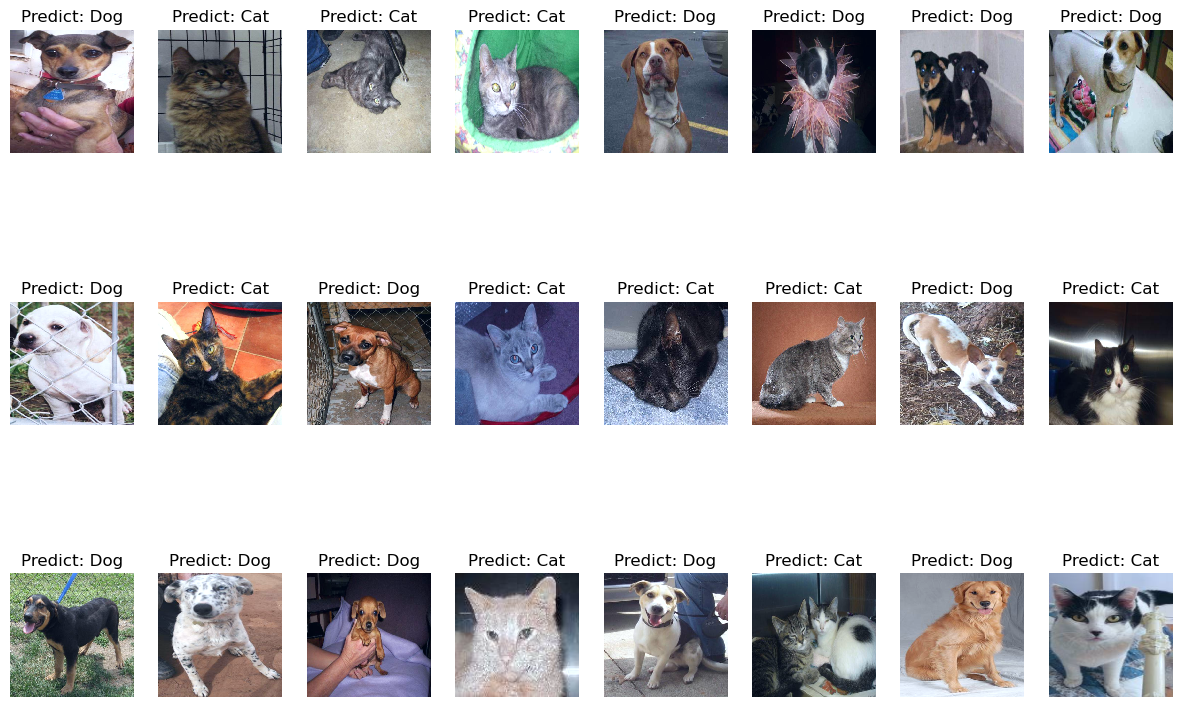

VALIDATION :  Acc: 0.981
SAVE_MODEL
Epoch 3/5
Epoch: [ 4/5]  Step [   1/1500]  Cross Entropy Loss: 0.0986 LR: 1.000e-04 
Epoch: [ 4/5]  Step [ 200/1500]  Cross Entropy Loss: 0.0977 LR: 1.000e-04 
Epoch: [ 4/5]  Step [ 400/1500]  Cross Entropy Loss: 0.0967 LR: 1.000e-04 
Epoch: [ 4/5]  Step [ 600/1500]  Cross Entropy Loss: 0.0962 LR: 1.000e-04 
Epoch: [ 4/5]  Step [ 800/1500]  Cross Entropy Loss: 0.0951 LR: 1.000e-04 
Epoch: [ 4/5]  Step [1000/1500]  Cross Entropy Loss: 0.0943 LR: 1.000e-04 
Epoch: [ 4/5]  Step [1200/1500]  Cross Entropy Loss: 0.0936 LR: 1.000e-04 
Epoch: [ 4/5]  Step [1400/1500]  Cross Entropy Loss: 0.0931 LR: 1.000e-04 
TRAIN : Loss: 0.0926 Acc: 0.9707


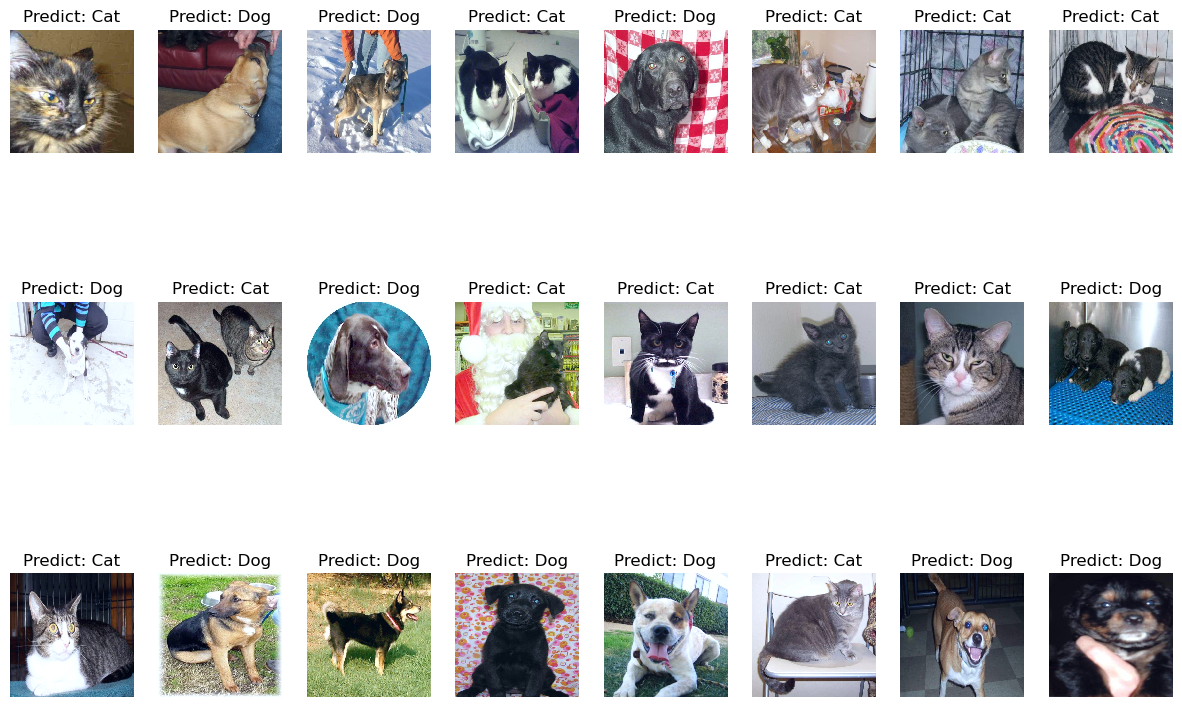

VALIDATION :  Acc: 0.980
Epoch 4/5
Epoch: [ 5/5]  Step [   1/1500]  Cross Entropy Loss: 0.0926 LR: 1.000e-04 
Epoch: [ 5/5]  Step [ 200/1500]  Cross Entropy Loss: 0.0918 LR: 1.000e-04 
Epoch: [ 5/5]  Step [ 400/1500]  Cross Entropy Loss: 0.0912 LR: 1.000e-04 
Epoch: [ 5/5]  Step [ 600/1500]  Cross Entropy Loss: 0.0903 LR: 1.000e-04 
Epoch: [ 5/5]  Step [ 800/1500]  Cross Entropy Loss: 0.0897 LR: 1.000e-04 
Epoch: [ 5/5]  Step [1000/1500]  Cross Entropy Loss: 0.0890 LR: 1.000e-04 
Epoch: [ 5/5]  Step [1200/1500]  Cross Entropy Loss: 0.0886 LR: 1.000e-04 
Epoch: [ 5/5]  Step [1400/1500]  Cross Entropy Loss: 0.0880 LR: 1.000e-04 
TRAIN : Loss: 0.0878 Acc: 0.9730


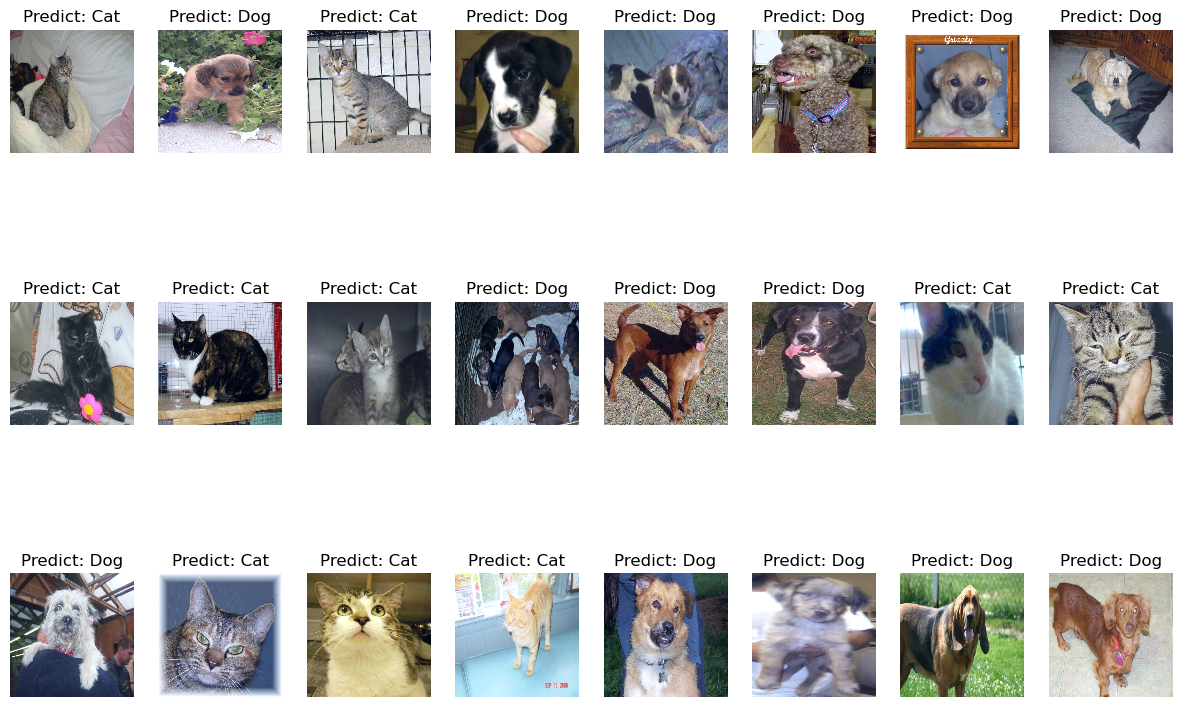

VALIDATION :  Acc: 0.980
TRAINNING PROCESS FINISH


In [ ]:
if __name__ == '__main__':
    
    main(cfg)

## inference

In [3]:
cfg['checkpoint'] = 'best_score.pth'

In [4]:
import torch.nn as nn
from tqdm import tqdm
from torchvision.models import VGG16_Weights
from torchvision import models, transforms
from PIL import Image
import torch
import numpy as np 


class_index = ["dog", "cat"]

class Predictor():
    def __init__(self, class_index):
        self.clas_index = class_index

    def predict_max(self, output): # [0.9, 0.1]
        max_id = np.argmax(output.detach().cpu().numpy())
        predicted_label = self.clas_index[max_id]
        return predicted_label


predictor = Predictor(class_index)

test_transform = transforms.Compose([
                transforms.Resize(size = cfg['DATASET']['image_size'], interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize(mean= (0.485, 0.456, 0.406) , std=(0.229, 0.224, 0.225))
    ])


def predict(img):
    # prepare network
    #use_pretrained = True
    net = models.vgg16(weights=None)
    net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
    net.eval()


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(cfg['checkpoint'], map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    net.to(device)
    
    # prepare input img
    img = test_transform(img)
    img = img.unsqueeze_(0) 
    img = img.to(device)
    
    # predict 
    output = net(img)
    response = predictor.predict_max(output)

    return response

## --> feed a img_path

In [7]:
cfg['img_path'] = 'classify_data/test1/3.jpg'

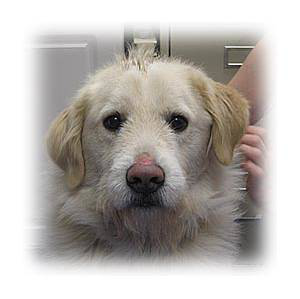

Predict : dog


In [8]:
img = Image.open(cfg['img_path'])
img = img.convert("RGB")
pred = predict(img)
display(img)
print(f"Predict : {pred}")